In [1]:
# connexion a wrds 
import wrds
db = wrds.Connection()

WRDS recommends setting up a .pgpass file.
pgpass file created at C:\Users\Gabri\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [44]:
# IMPORTS
import wrds
import pandas as pd
import numpy as np  # pour np.random.choice

np.random.seed(42)  # pour reproductibilité

# --- 1️ Connexion WRDS ---
def connect_wrds():
    print(">>> Connexion WRDS...")
    db = wrds.Connection()
    print(">>> Connexion WRDS OK.\n")
    return db

# --- 2️ Échantillon aléatoire de 50 entreprises S&P500 ---
def get_sp500_sample(df, db):
    """
    Retourne un échantillon de 50 tickers du S&P500 avec EPS disponibles.
    df : dataframe initial CRSP (permno + ticker)
    db : connexion WRDS
    """
    import numpy as np
    np.random.seed(42)  # reproductibilité

    # Tickres uniques
    unique_tickers = df["ticker"].dropna().unique()

    # Vérifier quels tickers ont des données EPS
    valid_tickers = []
    for ticker in unique_tickers:
        query = f"""
            SELECT 1
            FROM comp.fundq
            WHERE tic = '{ticker}'
            LIMIT 1
        """
        result = db.raw_sql(query)
        if not result.empty:
            valid_tickers.append(ticker)

    print(f">>> {len(valid_tickers)} tickers ont au moins un EPS disponible.")

    # Échantillon aléatoire de 50 tickers
    if len(valid_tickers) < 50:
        print("Attention : moins de 50 tickers avec EPS, on prend tout ce qui est disponible.")
        sample_tickers = valid_tickers
    else:
        sample_tickers = np.random.choice(valid_tickers, size=50, replace=False)

    # Construire le dataframe final (ticker + permno)
    sample = df[df["ticker"].isin(sample_tickers)][["permno", "ticker"]].drop_duplicates()

    print(f">>> Échantillon final : {len(sample['ticker'].unique())} tickers sélectionnés.")
    return sample


# --- 3️ Extraction des prix CRSP ---
def get_prices(db, sample):
    permno_list = "', '".join(sample['permno'].astype(str).unique())
    query = f"""
        SELECT date, prc, permno
        FROM crsp.dsf
        WHERE permno IN ('{permno_list}')
        ORDER BY permno, date
    """
    prices = db.raw_sql(query)
    print(">>> Prix téléchargés.\n")
    return prices

# --- 4️ Extraction des EPS Compustat ---
def get_eps(db, sample):
    tic_list = "', '".join(sample['ticker'].unique())
    query = f"""
        SELECT gvkey, tic AS ticker, datadate, epspxq
        FROM comp.fundq
        WHERE tic IN ('{tic_list}')
        ORDER BY gvkey, datadate
    """
    eps = db.raw_sql(query)
    print(">>> EPS téléchargés.\n")
    return eps

# --- 5️ Jointure CRSP ↔ EPS via ticker ---
def merge_prices_eps(prices, eps, sample):
    merged = prices.merge(sample, on='permno', how='left')
    merged = merged.merge(eps, on='ticker', how='left')
    
    # Filtrer EPS publié avant la date du prix
    merged = merged[merged['datadate'] <= merged['date']]
    print(">>> Jointure CRSP + EPS effectuée.\n")
    return merged

# --- 6️ Calcul Trailing P/E ---
def compute_trailing_PE(merged):
    merged = merged.sort_values(['permno', 'date'])
    merged['eps_ttm'] = merged.groupby('permno')['epspxq'].rolling(4).sum().reset_index(level=0, drop=True)
    merged['eps_ttm'] = merged.groupby('permno')['eps_ttm'].ffill()
    merged['trailing_pe'] = merged['prc'] / merged['eps_ttm']
    print(">>> Trailing EPS & P/E calculés.\n")
    return merged

# --- 7️ Pipeline complet ---
def run_pipeline():
    db = connect_wrds()

    # Charger la liste S&P500 depuis CRSP
    df = db.raw_sql("""
        SELECT permno, ticker
        FROM crsp.msenames
        WHERE shrcd IN (10,11)
        AND exchcd IN (1,2,3)
    """)

    sample = get_sp500_sample(df, db)
    prices = get_prices(db, sample)
    eps = get_eps(db, sample)

    merged = merge_prices_eps(prices, eps, sample)
    final = compute_trailing_PE(merged)
    
    # Filtrer pour les dates après 2003
    final['date'] = pd.to_datetime(final['date'])
    final = final[final['date'] > "2003-01-01"]

    print(final.head())
    return final

# --- 8️ Exécution ---
if __name__ == "__main__":
    final_df = run_pipeline()
    final_df.to_csv("SP500_trailing_PE.csv", index=False)
    print(">>> Pipeline terminé, CSV sauvegardé.\n")


>>> Connexion WRDS...
WRDS recommends setting up a .pgpass file.
pgpass file created at C:\Users\Gabri\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
>>> Connexion WRDS OK.

>>> 13488 tickers ont au moins un EPS disponible.
>>> Échantillon final : 50 tickers sélectionnés.
>>> Prix téléchargés.

>>> EPS téléchargés.

>>> Jointure CRSP + EPS effectuée.

>>> Trailing EPS & P/E calculés.

              date    prc  permno ticker   gvkey    datadate  epspxq  eps_ttm  \
2298858 2021-06-30  26.06   11628   CPBI  043152  2021-06-30    <NA>      NaN   
2298875 2021-07-01  26.17   11628   CPBI  043152  2021-06-30    <NA>      NaN   
2298892 2021-07-02  25.81   11628   CPBI  043152  2021-06-30    <NA>      NaN   
2298909 2021-07-06  25.29   11628   CPBI  043152  2021-06-30    <NA>      NaN   
2298926 2021-07-07  24.85   11628   CPBI  043152  2021-06-30    <

### Nettoyage et préparation des données

1. **Renommer les colonnes** pour plus de clarté : `prc → prix`, `epspxq → EPS`, `eps_ttm → EPS_MOBILE`, `trailing_pe → Prix_bene`.

2. **Trier et convertir les dates** par entreprise (`permno`) et date, supprimer colonnes temporaires inutiles.

3. **Filtrer les anciennes données** : garder uniquement les EPS à partir de 2003.

4. **Remplir les valeurs manquantes** (NaN) par forward/backfill par entreprise et supprimer les tickers avec >30% de NaN.

5. **Convertir en float** les colonnes `prix` et `EPS`.

6. **Supprimer doublons** par ticker et date, garder la dernière ligne.

7. **Préparer les données trimestrielles** : garder `permno`, `datadate`, `epspxq`, une seule ligne par trimestre et par entreprise.

8. **Calculer le BPA glissant sur 4 trimestres** (`EPS_MA4`) en moyenne des 4 derniers trimestres pour chaque entreprise.

9. **Fusionner les données journalières et trimestrielles** : associer à chaque ligne quotidienne le BPA glissant du dernier trimestre disponible (`merge_asof` avec `by='permno'`).

10. **Calculer les ratios prix/BPA** :  
    - Historique : `prix / EPS`  
    - Glissant : `prix / EPS_MA4`


In [155]:
# nettoyage et préparations des données 
def nettoyage_df(df):
    
    # par convention on prend la valeur des prix en absolue
    df['prc'] = df['prc'].abs()

    # Renommer les colonnes proprement
    df = df.rename(columns={
        "prc": "prix",
        "epspxq": "EPS",
        "eps_ttm": "EPS_MOBILE",
        "trailing_pe": "Prix_bene"
    })
    
    # Trier les données par entreprise et par date
    df = df.sort_values(['permno', 'date'])
    
    # Supprimer les colonnes temporaires
    df = df.drop(columns=['EPS_MOBILE', 'Prix_bene'])
    
    # Convertir les dates
    df['date'] = pd.to_datetime(df['date'])
    df['datadate'] = pd.to_datetime(df['datadate'])
    
    # Filtrer les EPS trop anciens : garder EPS >= 2003
    df = df[df['datadate'] >= "2003-01-01"]
    
    # Remplir les NaN dans EPS par forward-fill + backfill par permno
    df['EPS'] = df.groupby('permno')['EPS'].transform(lambda x: x.ffill().bfill())
    
    # Garder uniquement les tickers avec moins de 30% de NaN sur EPS
    nan_eps_pct = df.groupby('ticker')['EPS'].apply(lambda x: x.isna().mean())
    tickers_valides = nan_eps_pct[nan_eps_pct <= 0.30].index
    df = df[df['ticker'].isin(tickers_valides)]
    
    # Convertir les colonnes en float
    float_cols = ['prix', 'EPS']
    for col in float_cols:
        df[col] = pd.to_numeric(df[col])
    
    # Vérifier le type des colonnes
    print("Types de données :\n", df.dtypes)
    
    # Trier par ticker et date pour cohérence
    df = df.sort_values(['permno', 'date'], ascending=True).reset_index(drop=True)
    df = df.drop_duplicates(subset=['ticker', 'date'], keep='last')
    
    # défintion de df quarter 
    df_quarter = final_df[['permno', 'datadate', 'epspxq']].dropna()

    # Convertir datadate en datetime si ce n’est pas déjà le cas
    df_quarter['datadate'] = pd.to_datetime(df_quarter['datadate'])

    # Garder une seule ligne par permno et trimestre
    df_quarter = df_quarter.sort_values(['permno', 'datadate'])
    df_quarter = df_quarter.drop_duplicates(subset=['permno', 'datadate'], keep='first')

    #  Calcul EPS mobile 4 trimestres
    df_quarter['EPS_MA4'] = (
        df_quarter
        .groupby('permno')['epspxq']
        .rolling(window=4, min_periods=4)
        .mean()
        .reset_index(level=0, drop=True)
    )

    # Trier globalement par date pour deux df
    df = df.sort_values('date').reset_index(drop=True)
    df_quarter = df_quarter.sort_values('datadate').reset_index(drop=True)

    #  Merge des deux df
    df = pd.merge_asof(
        df,
        df_quarter[['permno', 'datadate', 'EPS_MA4']],
        left_on='date',
        right_on='datadate',
        by='permno',
        direction='backward'
    )

    # Vérifier les dates min/max
    print("Date minimale :", df['date'].min())
    print("Date maximale :", df['date'].max())

    # Supprimer les lignes avec NaN
    df = df.dropna(subset=["EPS_MA4"])

    # calcule du ratio p/b historique et glissant 
    df["ratio_pb_h"] = df["prix"] / df["EPS"] # histo 
    df["ratio_pb_MA"] = df["prix"] / df["EPS_MA4"] # glissant

    # présence de NaN par colone 
    df.isna().sum()

    # Supprimer les colonnes doublés 
    df = df.drop(columns=['datadate_y'])
    
    # Renommer la colone doublé 
    df = df.rename(columns={
        "datadate_x": "datadate"
    })

    # trie final par ticker et date 
    df = df.sort_values(["ticker", "date"]).reset_index(drop=True)

    return df

# résultats 
df = nettoyage_df(final_df)
df.tail() # visualisation des résultats 

Types de données :
 date        datetime64[ns]
prix               Float64
permno               Int64
ticker      string[python]
gvkey       string[python]
datadate    datetime64[ns]
EPS                Float64
dtype: object
Date minimale : 2003-01-31 00:00:00
Date maximale : 2024-12-31 00:00:00


,date,prix,permno,ticker,gvkey,datadate,EPS,EPS_MA4,ratio_pb_h,ratio_pb_MA
52104,2024-12-24,135.03,90175,XPO,144998,2024-09-30,0.81,0.7950,166.703704,169.849057
52105,2024-12-26,133.17,90175,XPO,144998,2024-09-30,0.81,0.7950,164.407407,167.509434
52106,2024-12-27,132.25999,90175,XPO,144998,2024-09-30,0.81,0.7950,163.283938,166.364767
52107,2024-12-30,132.59,90175,XPO,144998,2024-09-30,0.81,0.7950,163.691358,166.779874
52108,2024-12-31,131.14999,90175,XPO,144998,2024-12-31,0.65,0.8325,201.769215,157.537526


In [156]:
# statistique descriptives des colonnes sélectionnés (par actions)
stat_des = df.groupby("ticker")[['prix', 'EPS', 'ratio_pb_h', 'ratio_pb_MA']].describe()
print(stat_des)

          prix                                                          \
         count       mean        std     min      25%     50%      75%   
ticker                                                                   
ASHW    1463.0   7.191352   2.316894    1.62      6.2    7.79     8.46   
BMTC    4724.0   27.70186   9.053802   12.68    20.94  23.865  33.8575   
COSN     558.0   4.778236   2.006079    1.97   2.8225   4.735      6.3   
CPBI     502.0  13.884484   3.919675     9.0     10.2  13.695    16.55   
CRRC    3068.0  25.815437  14.214511    5.86    13.96   17.42     38.8   
CRZY     155.0  15.433168   1.234403    13.5    14.72   15.05   15.495   
FACE    1533.0   6.312403   5.365217     1.0      3.0    3.66     9.16   
FAT     1809.0   6.763803   2.163175    1.76     5.25    6.52     7.98   
HOOK    1573.0   7.368408   6.312732   0.421     1.17    5.28    14.52   
HOTJ     541.0   1.828089   1.269812  0.0498      0.8    1.72     2.61   
IRM     5477.0  37.468936  15.738589  

c:\Users\Gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:4671: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


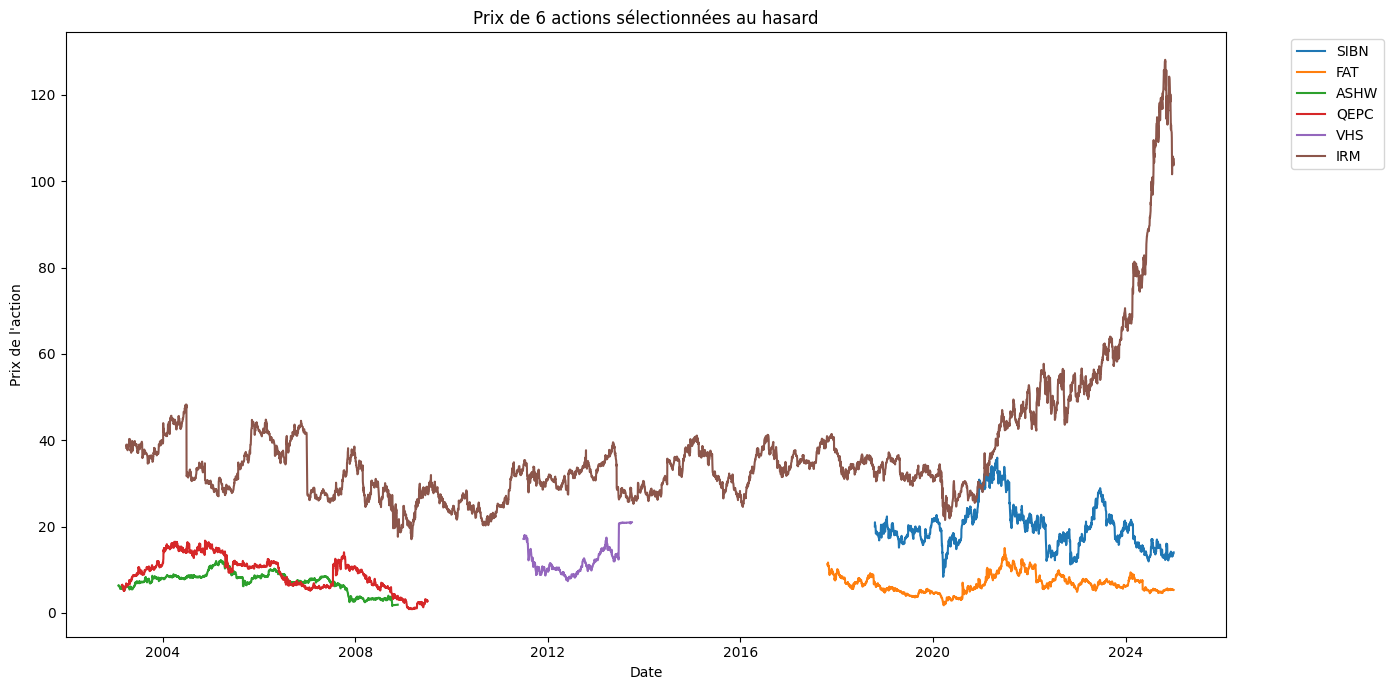

In [159]:
import matplotlib.pyplot as plt
import numpy as np

# Sélectionner 6 tickers au hasard
tickers_unique = df['ticker'].unique()
tickers_alea = np.random.choice(tickers_unique, size=6, replace=False)

plt.figure(figsize=(14, 7))
for t in tickers_alea:
    df_ticker = df[df['ticker'] == t]
    plt.plot(df_ticker['date'], df_ticker['prix'], label=t)

plt.xlabel("Date")
plt.ylabel("Prix de l'action")
plt.title("Prix de 6 actions sélectionnées au hasard")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # légende à côté
plt.tight_layout()
plt.show()



In [161]:
# présence de NaN par colone 
df.isna().sum()

date           0
prix           1
permno         0
ticker         0
gvkey          0
datadate       0
EPS            0
EPS_MA4        0
ratio_pb_h     1
ratio_pb_MA    1
dtype: int64